## Investigation of [May 2015 Reddit Comments](https://www.kaggle.com/reddit/reddit-comments-may-2015)

The database has one table, May2015, with the following [fields](https://github.com/reddit/reddit/wiki/JSON):
 `created_utc, ups, subreddit_id, link_id, name, score_hidden, author_flair_css_class, author_flair_text, subreddit, id, removal_reason, gilded, downs, archived, author, score, retrieved_on, body, distinguished, edited, controversiality, parent_id`
 
 --------
 
 It takes:
 - 1.2 seconds to grab 0.1 mln
 - 10 secs to grab 1 mln
 - 5 minutes secs to grab 10 mln.

Data have 54504410 comments (~55 mln), so it is expensive to get all of it with all the columns. After some preliminary analysis, I found that many columns are useless.

 - name (just an id with some prefix)
 - id (an string, which increases: cqug90g, cqug90h, ...)
 - author_flair_css_class, author_flair_text (text and css class of authors flair
 - downs, archived (is always 0)
 - retrieved_on (when was the comment extracted by API parser)
 - score (the same value as ups)
 - subreddit_id (is the ID of subreddit)
 - score_hidden (whether the comment score is currently hidden)
 - removal_reason (s always None)
 
A few other fields that were not helpful for me: `link_id`, `parent_id`, `edited`, `distinguished`. 

The last one takes only 4 different values and if I ever will need to use it here is a snippet:

    type_distinguished = {'moderator': 1, 'admin': 2, 'special': 3}
    df['distinguished'] = df['distinguished'].apply(lambda x: type_distinguished.get(x, 0))
    
The most interesting data will be most probably in the body statement. I will leave this investigation to another notebook. Will take a look at the low-hanging fruits and prepare a list of interesting questions to ask during the NLP part.

In [1]:
import pandas as pd
import numpy as np
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [2]:
%%time
query = """
    SELECT created_utc, ups, subreddit, gilded, author, controversiality
    FROM May2015
"""
df = pd.read_sql(query, sqlite3.connect('input/database.sqlite'), parse_dates=['created_utc'])

CPU times: user 6min 15s, sys: 6min 31s, total: 12min 47s
Wall time: 22min 1s


The original file is 30Gb, and even after removing some columns it is still big. After investigating the values, I found that `controversiality` is boolean. Also found that the maximum value of `gilded` is < 256 and the maximum value of `ups` is < 32k.

So I am just trying to decrease the amount of memory needed.

In [3]:
%%time
df['controversiality'] = df['controversiality'].apply(lambda x: x == 1)
df['gilded'] = df['gilded'].astype(np.int8)
df['ups'] = df['ups'].astype(np.int16)

CPU times: user 16.2 s, sys: 5.01 s, total: 21.2 s
Wall time: 32.9 s


### Time distribution
Let's see how does the distribution between number of comments created each day looks like.

CPU times: user 11min 12s, sys: 7min 37s, total: 18min 50s
Wall time: 22min 10s


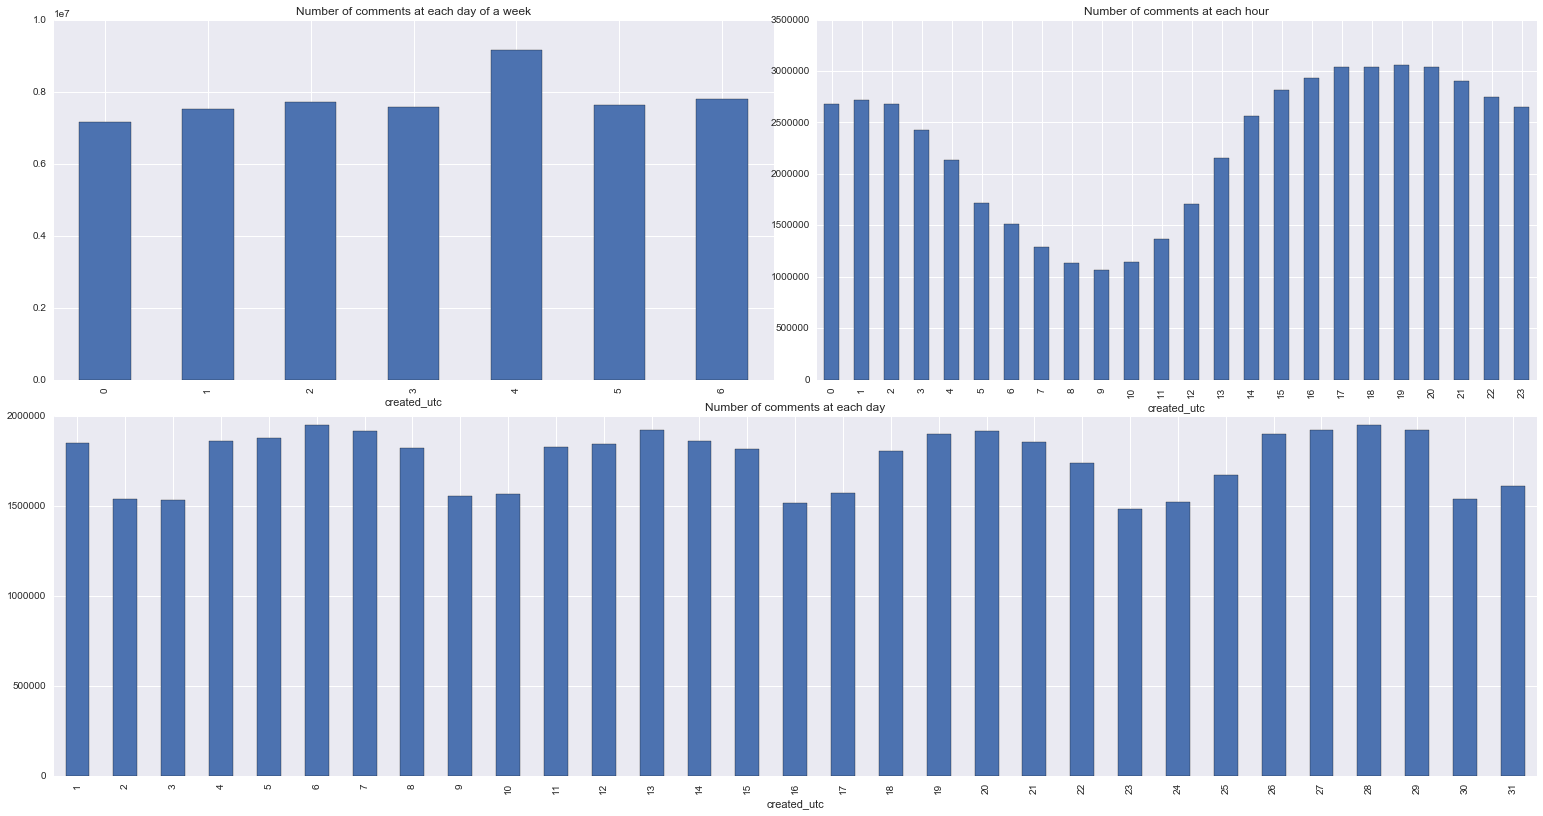

In [4]:
%%time
fig=plt.figure(figsize=(20, 10))

df.groupby(df['created_utc'].map(lambda x: x.weekday())).size().plot(
    'bar', title='Number of comments at each day of a week', ax=fig.add_axes((0, 0, 0.5, 0.5))
);
df.groupby(df['created_utc'].map(lambda x: x.hour)).size().plot(
    'bar', title='Number of comments at each hour', ax=fig.add_axes((0.53, 0, 0.5, 0.5))
);
df.groupby(df['created_utc'].map(lambda x: x.day)).size().plot(
    'bar', title='Number of comments at each day', ax=fig.add_axes((0, -0.55, 1.03 ,0.5))
);

As we see Friday has the biggest amount of comments (a day before weekends, people have nothing to do).

When I looked at the distribution for each hour, I saw an interesting trend. The bars look like a sine wave with the lowest ~9 and the highest at 19. This would not be strange if the timestamp would be in the timezone of the person who commented (because clearly there are more people who follow a regular active/sleep cycle). But here we are speaking about international audience which means that they come from different timezones. **So may be the audience is not so international as I expected.**

The last graph shows that this trend continues during the longer period of time, and that the number of comments at each specific day of the week is not really changing.

When I have done the distribution between the minutes, the bars looked approximately the same. This means that there is no real difference between the number of comments sent at different minutes.

---- 
### Subreddits

Let's investigate the comments in the various subreddits. It is clear that there will be a few very very popular subreddits with huge amount of comments and many many subreddits with close to 1 comment. It would be also interesting to take a look at the most popular subreddits. 

Before I will move ahead, I will create a helper function that creates 2 plots (I will be using it often).

In [5]:
def plot_distribution_popular(df, title1, title2, num=60):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
    
    df.plot(title=title1, xticks=[], logy=True, ax=axes[0]);
    df[:num].plot(title=title2, kind='bar', logy=True, ax=axes[1]);

CPU times: user 23.1 s, sys: 26.1 s, total: 49.2 s
Wall time: 1min 45s


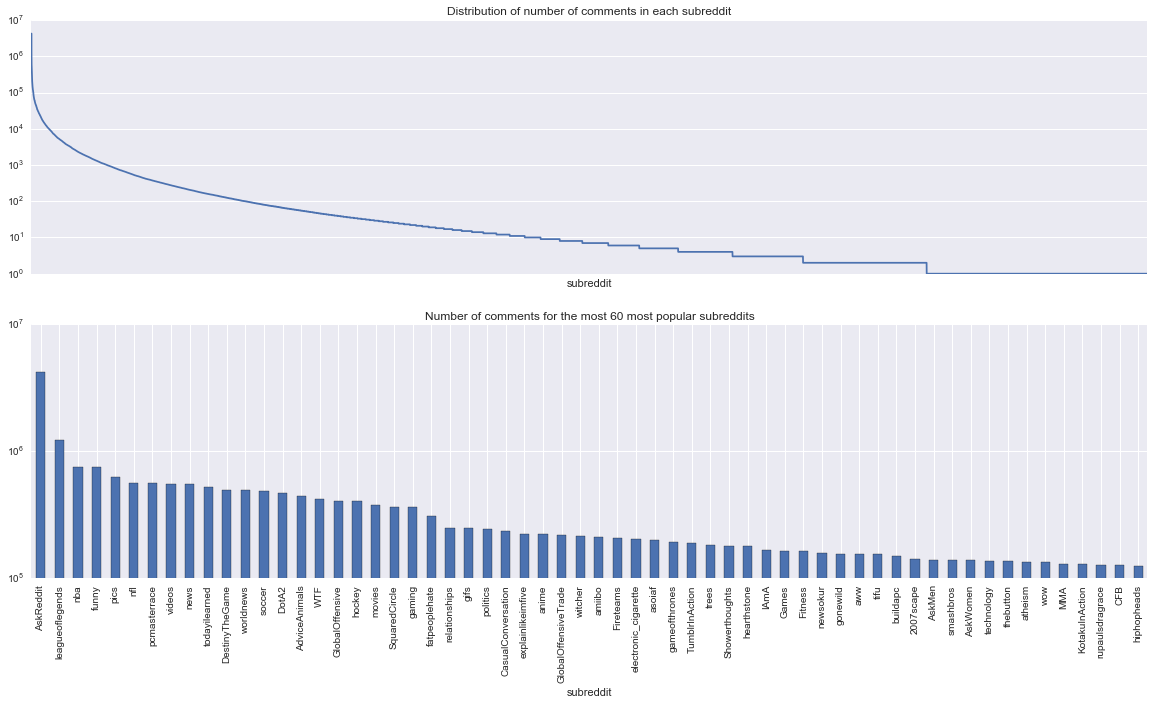

In [6]:
%%time
plot_distribution_popular(
    df.groupby(df['subreddit']).size().sort_values(ascending=False),
    "Distribution of number of comments in each subreddit",
    "Number of comments for the most 60 most popular subreddits"
)

As we see from the first plot $~1/5$ of all subreddits have only 1 comment, ~$1/2$ has less than 10 comments. Nothing really surprising about most popular subreddits: people like movies, music, games, random blabbing.

**Interesting question to NLP:**
> can we distinquesh between very popular subreddits based on the text body

### Authors
Now let's see who writes these comments. Expect to see the same long tail stuff. 

CPU times: user 2min 4s, sys: 8min 20s, total: 10min 25s
Wall time: 21min 9s


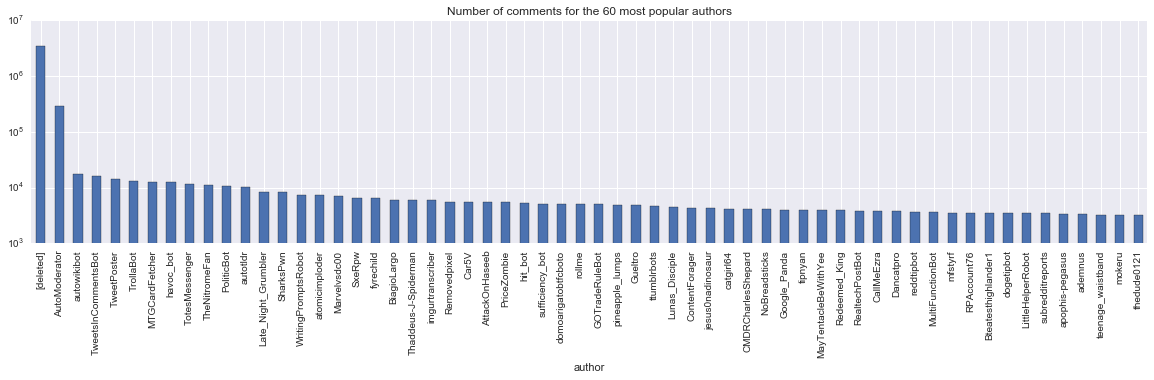

In [7]:
%%time
plt.figure(figsize=(20, 4))
df.groupby(df['author']).size().sort_values(ascending=False)[:60].plot(
    'bar', logy=True, title="Number of comments for the 60 most popular authors"
);

It looks like there are a lot of comments which are most probably deleted. Also some of them automoderated. It makes sense to take a look at them.

Looking at `df[df['author'] == 'AutoModerator'].value_counts().sort_values(ascending=False)` I saw that all the body text is huge wall of text of of automatic warning that just tells something like this 'you have done something wrong, so we removed it'. 

Similar thing is with `df[df['author'] == 'AutoModerator'].value_counts().sort_values(ascending=False)`. Huge majority (99%) is just value `[deleted]`. Others are either an automated text or a short ok/thank/you too messages. 

Do not see any value having this around, so I will just get rid of them

In [8]:
%%time
df = df[(df['author'] != '[deleted]') & (df['author'] != 'AutoModerator')]

CPU times: user 32.2 s, sys: 2min 4s, total: 2min 36s
Wall time: 5min 40s


CPU times: user 2min 37s, sys: 8min 28s, total: 11min 5s
Wall time: 21min 40s


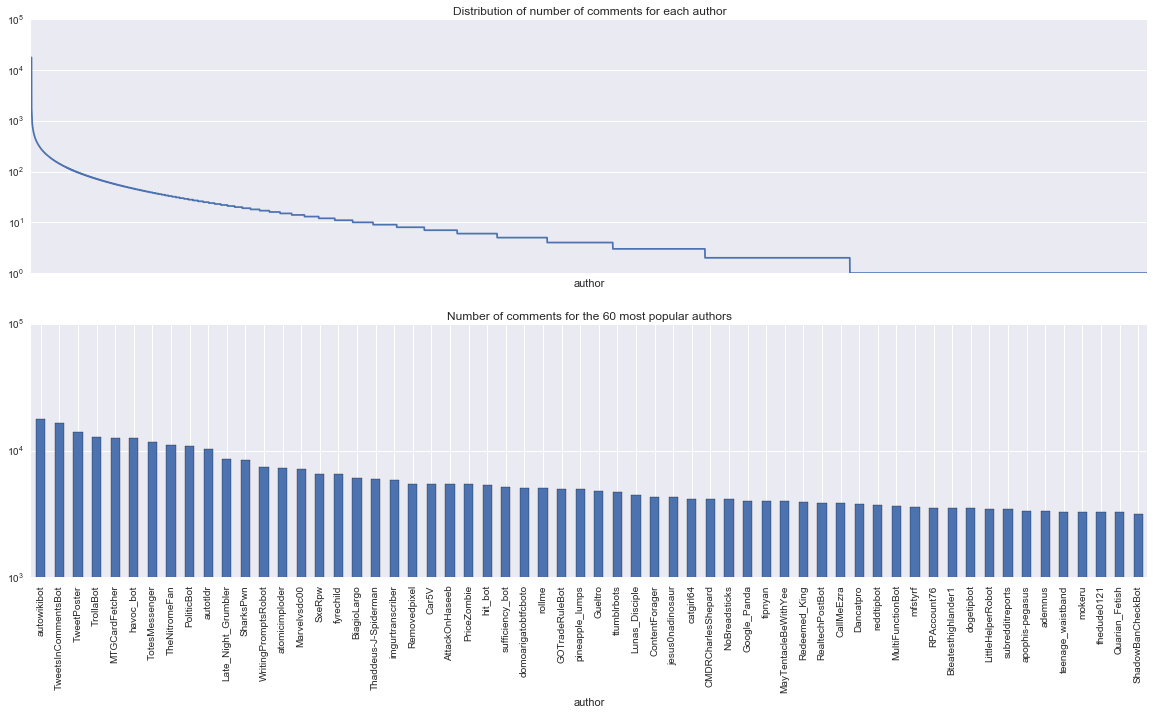

In [9]:
%%time
plot_distribution_popular(
    df.groupby(df['author']).size().sort_values(ascending=False),
    "Distribution of number of comments for each author",
    "Number of comments for the 60 most popular authors",
)

From the first plot we see that a hope for humanity was partially restored. $~1/3$ of the authors posted 1 comment and $~3/4$ posted less than 10 comments.

Apparently some people have absolutely nothing to do with their life. $10^4$ comments on reddit in a month. This is 14 comments per hour non stop. Some of them suggest that they are bots (`autowikibot`, `politicBot`, but I believe that all top 60 are bots.

Would be interesting to investigate their speech pattern, where do they post and how many upvotes do they have.

**Interesting question to NLP:**
> can we distinquesh between very popular authors based on the text body


----
### Subreddits and authors

Now let's combine both subreddits and authors and find subreddits with the biggest amount of authors.

CPU times: user 12min 4s, sys: 1h 15min 34s, total: 1h 27min 39s
Wall time: 3h 39min 58s


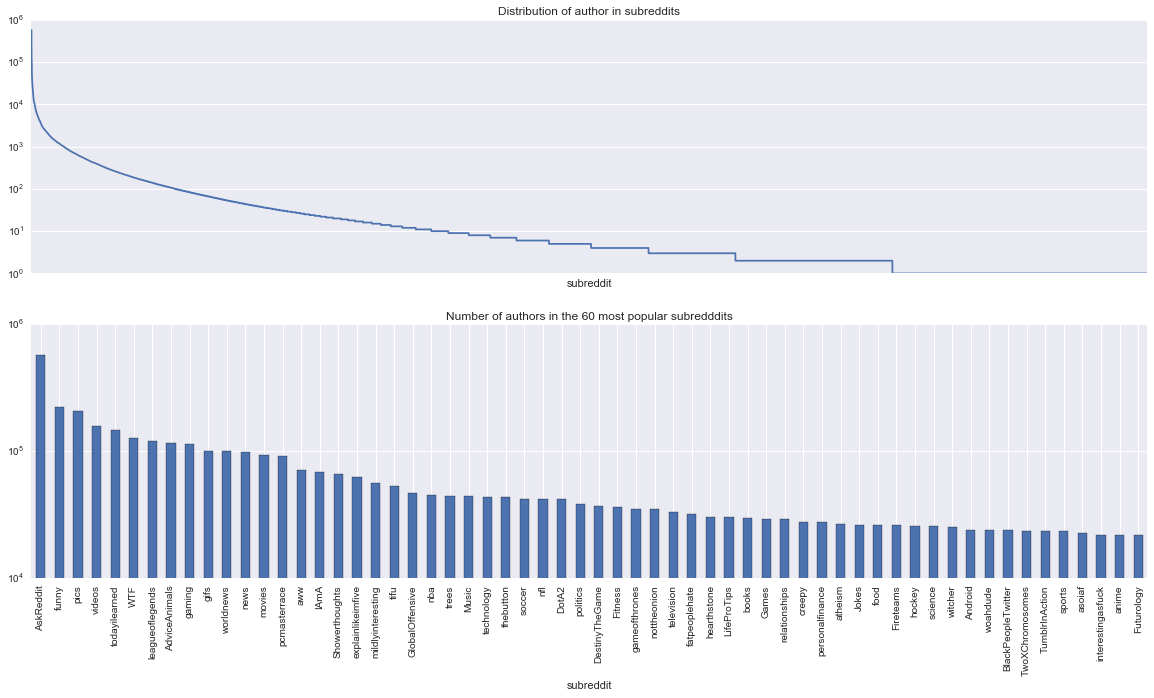

In [10]:
%%time
plot_distribution_popular(
    df.groupby('subreddit')['author'].nunique().sort_values(ascending=False),
    "Distribution of author in subreddits",
    "Number of authors in the 60 most popular subredddits",
)

----
### Scores
Let's see how the comments were recieved by the audience. 

I would expect that a lot of comments get close to 0 score, I also would expect votes to be skewed towards positive values and clearly there will be a long tail. Investigating `df['ups'].value_counts()` shows that my expectations were wrong. **Majority of the comments have 1 vote.** Then 2, 3, and only then 0 votes.

This clearly need more detailed investigation, because the grouping is not smart (I have to group comments). I will not do anything with near 0 votes, but I will group highly positive and highly negative comments.

In [11]:
print len(df[df['ups'] < -10]), len(df[df['ups'] < -50]), len(df[df['ups'] < -100]), len(df[df['ups'] < -500])
print len(df[df['ups'] > 10]), len(df[df['ups'] > 50]), len(df[df['ups'] > 100]), len(df[df['ups'] > 500]), len(df[df['ups'] > 1000]), len(df[df['ups'] > 5000])

243602 12819 2487 23
3977268 750247 352454 55865 22687 136


In [12]:
down_ranges = [-5000, -1000, -500, -100, -50, -10]
up_ranges   = [10, 50, 100, 500, 1000, 5000, 10000]

for i in xrange(len(down_ranges) - 1):
    s, e = down_ranges[i], down_ranges[i + 1]
    df.loc[(df['ups'] >= s) & (df['ups'] < e), 'ups'] = (s + e) / 2
    
for i in xrange(len(up_ranges) - 1):
    s, e = up_ranges[i], up_ranges[i + 1]
    df.loc[(df['ups'] > s) & (df['ups'] <= e), 'ups'] = (s + e) / 2

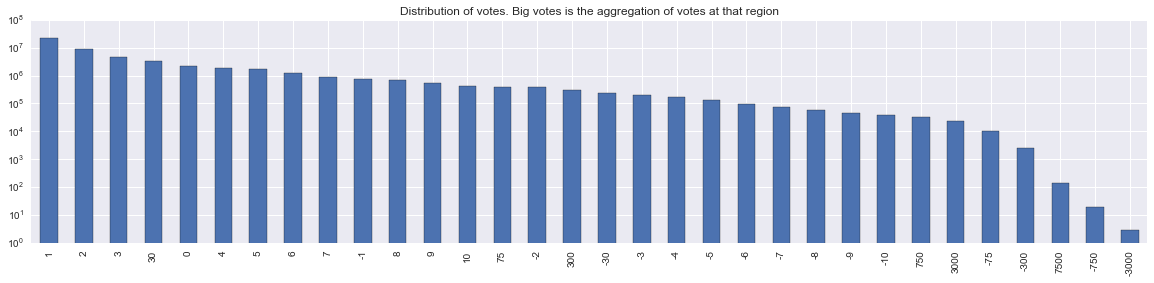

In [13]:
plt.figure(figsize=(20, 4))
df['ups'].value_counts().plot('bar', logy=True, title="Distribution of votes. Big votes is the aggregation of votes at that region");

Majority of the comments recived a positive feedback. There is higher probability that a comment will recive from 10 till 50 upvotes than it will recive 0 upvotes. Look at the position of the first negative score (10-th from the left). And just for fun, the last look at the distribution of the positive/negative/neutral comments.

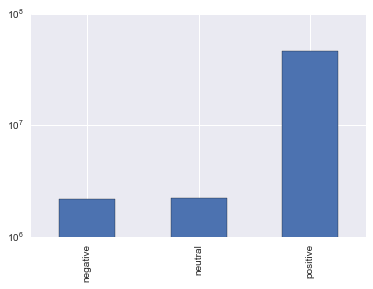

In [14]:
pd.Series({
    'positive': len(df[df['ups'] > 0]),
    'neutral': len(df[df['ups'] == 0]),
    'negative': len(df[df['ups'] < 0])
}).plot('bar', logy=True);

**Interesting question to NLP:**
> What makes a comment highly positively/negatively pursuited by the crowd. 

### Gilded comments
As far as I understood, gilded comment means that some other user endorsed the comment (by making some monetary donation). It would be interesting to see the score distribution for these comments.

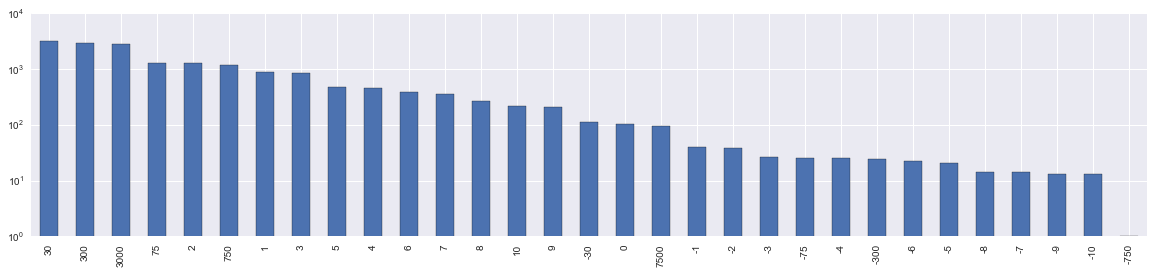

In [15]:
plt.figure(figsize=(20, 4))
df[df['gilded'] > 0]['ups'].value_counts().plot('bar', logy=True);

As we see clearly gilded comments have reasonably high score. But we also see that sometimes the comment is gilded nonetheless of it's unpopularity (~-30 or even some with ~-300)

### Controversiality
Previously I converted `controversiality` to a boolean value. Now it is time to ivestigate it. Based on my understanding, this field is marked when during some time a comment received significant amount of upvotes and downvotes.

Let's check for the most controversial authors, the most controversial subreddits and the scores of controversial comments.

In [16]:
print "Percent of controversial comments", len(df[df['controversiality']]) / float(len(df))

Percent of controversial comments 0.0240061201902


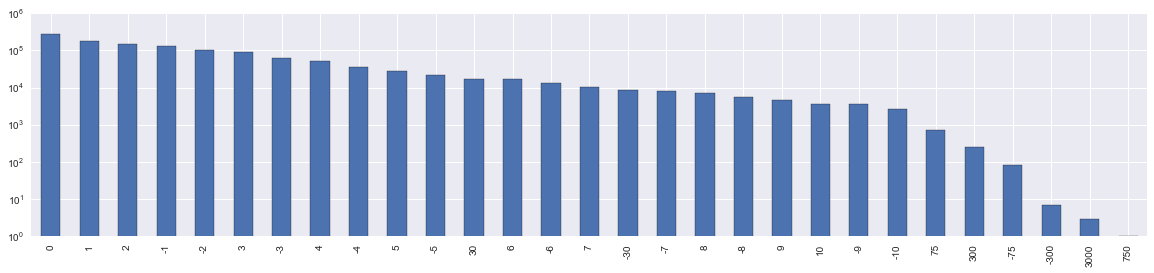

In [17]:
plt.figure(figsize=(20, 4))
df[df['controversiality']]['ups'].value_counts().plot('bar', logy=True);

The distribution of scores in controversial comments is significantly different from the distribution of all comments and the distribution of gilded comments. They are dominated by small score with the maximum at 0.

Ok, with scores everything was simple, but in order to find controversial authors or controversial subreddits (the approach will be the same) it is not enough just to group by a topic and sort. This is because clearly a topic with 10k comments has higher chance of getting 10 controversial comments than a topic with 15 comments.

To overcome this I will caclulate the percent of controversial comments in each topic and then exclued topics with less than min_size comments.

In [18]:
def analyzeControversial(column, min_size):
    res = df[[column, 'controversiality']].groupby(column).mean()
    tmp = res.join(pd.DataFrame(df.groupby(df[column]).size(), columns=["cnt"]))
    return tmp[tmp['cnt'] >= min_size].sort_values('controversiality', ascending=False)    

In [19]:
%%time
tmp = analyzeControversial('subreddit', 1000)

CPU times: user 43.6 s, sys: 1min 28s, total: 2min 11s
Wall time: 4min 28s


In [20]:
tmp.head(n=20)

,controversiality,cnt
subreddit,,
UkrainianConflict,0.192875,17908
samharris,0.171821,1455
russia,0.161770,13581
nl_Kripparrian,0.141176,1190
svenskpolitik,0.137472,3157
Polska,0.128440,1744
serialpodcast,0.126156,40212
Israel,0.112905,10965
Conservative,0.108730,11947


As we see, majority of controversial comments come from controversial topics (politics), but it looks like podcasters and masturbators also have things they can't agree upon.

Lets look at the least controversial stuff.

In [21]:
print [str(i) for i in tmp[tmp['controversiality'] == 0].index.values.tolist()]

['superleague', 'inFAMOUSRP', 'Thaumaturgy', 'TeamRedditTeams', 'hubchargen', 'huntersbell', 'TapTapInfinity', 'identifythisfont', 'TTPloreplaycentral', 'sufficiencybot', 'indiegameswap', 'infertility', 'SupersRP', 'Stuff', 'SteamPunkPowers', 'kancolle_ja', 'TheInnBetween', 'TheRedLion', 'watchinganime', 'AsTheClockTurns', 'TheVeneration', 'ArtJunkie', 'hcteams', 'havoc_bot', 'TotalDramaRoleplay', 'TotalDramaRoleplay2', 'TotalDramaWerewolf', 'AquamarinesDen', 'hampan', 'AppNana', 'TradeOrGift', 'Triumph', 'TroveCreations', 'kinksters_gone_wild', 'ShadowBan', 'SburbRP', 'maddenmobilebuysell', 'mcservers', 'PowerShell', 'PrivateFiction', 'BeautyAddiction', 'RPGStuck', 'BeardedDragons', 'BayStars', 'RandomActsOfTf2', 'RandomActsofCards', 'BasketballGMFantasy', 'RandomActsofMakeup', 'BankBallExchange', 'usedpanties', 'BakaNewsJP', 'uvtrade', 'SaintsFC', 'BTFC', 'lowlevelaware', 'BBWGW', 'RapWars', 'RateMyMayor', 'RecruitCS', 'vapeitforward', 'AutoModerator', 'Riftvielrpg', 'RunnerHub', 'le

Wow, there is a lot of topics with significant amount of comments where non of them was marked as controversial.

In [22]:
%%time
tmp = analyzeControversial('author', 1000)

CPU times: user 3min 24s, sys: 12min 34s, total: 15min 59s
Wall time: 25min 3s


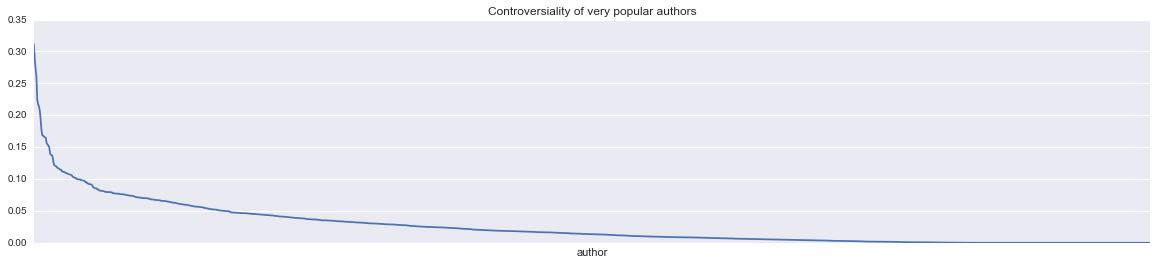

In [23]:
plt.figure(figsize=(20, 4))
tmp['controversiality'].plot(xticks=[], title="Controversiality of very popular authors");

In [25]:
tmp.head(5)

,controversiality,cnt
author,,
summer_dreams,0.311516,1207
orion4321,0.290654,1070
Lonly-jap,0.273373,1690
SavannaJeff,0.261029,1088
Tenaciousceeee,0.224701,1255


As we see there is a small amount of users who constantly post controversial comments (may be they are trolls). Amost all popular commenters have at least one comment marked as controversial. And approximately 1/5 of popular commenters have never posted anything controversial.

This is all for todays analysis, will just remind a few topics for NLP:

 - can we distinquesh between very popular subreddits based on the text body
 - can we distinquesh between very popular authors based on the text body
 - what makes a comment highly positively/negatively pursuited by the crowd
 - what makes a comment controversial